# Activation Functions Comparison: ReLU, GELU, and Beyond

Activation functions are one of the most fundamental design choices in neural networks. They introduce **non-linearity**, allowing a network to learn complex patterns beyond simple linear transformations.

Without activation functions, stacking multiple layers would be mathematically equivalent to a single linear layer — no matter how deep the network.

---

## What This Notebook Covers

- What activation functions are and why they matter
- Mathematical definitions and intuitions for six common functions
- Side-by-side visualizations: function output, derivative, and behavior under different inputs
- A practical training experiment comparing ReLU vs GELU on a real dataset
- Takeaways on when to use which activation

---

## Activation Functions Covered

| Function | Key Idea |
|---|---|
| Sigmoid | Squashes output to (0, 1); oldest standard |
| Tanh | Zero-centered version of sigmoid |
| ReLU | Simple, fast; most widely used |
| Leaky ReLU | Fixes the "dying ReLU" problem |
| ELU | Smooth negative side; faster convergence |
| GELU | Probabilistic gating; used in Transformers |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.special import erf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plot style
plt.rcParams.update({
    'figure.dpi': 120,
    'font.family': 'DejaVu Sans',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})

print('Libraries loaded successfully.')

Libraries loaded successfully.


---

## 1. Mathematical Definitions

Each activation function takes a real number `x` and returns a transformed value. Below are the exact formulas used.

In [2]:
x = np.linspace(-6, 6, 1000)

# --- Function definitions ---

def sigmoid(x):
    """Maps any value to (0, 1). Classic for binary classification output."""
    return 1 / (1 + np.exp(-x))

def tanh(x):
    """Zero-centered; output in (-1, 1). Better than sigmoid for hidden layers."""
    return np.tanh(x)

def relu(x):
    """Max(0, x). Simple, fast, sparse activation."""
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    """Like ReLU but allows a small gradient for x < 0 to prevent dead neurons."""
    return np.where(x >= 0, x, alpha * x)

def elu(x, alpha=1.0):
    """Exponential Linear Unit. Smooth for negatives, faster convergence."""
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def gelu(x):
    """
    Gaussian Error Linear Unit.
    GELU(x) = x * Phi(x)  where Phi is the cumulative distribution of N(0,1).
    Intuitively: gates the input probabilistically — large positives pass through,
    large negatives are suppressed, values near zero are partially allowed.
    Used in GPT, BERT, and most modern Transformers.
    """
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

# --- Derivative definitions (for backpropagation intuition) ---

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def d_tanh(x):
    return 1 - np.tanh(x)**2

def d_relu(x):
    return np.where(x > 0, 1.0, 0.0)

def d_leaky_relu(x, alpha=0.01):
    return np.where(x >= 0, 1.0, alpha)

def d_elu(x, alpha=1.0):
    return np.where(x >= 0, 1.0, alpha * np.exp(x))

def d_gelu(x):
    cdf = 0.5 * (1 + erf(x / np.sqrt(2)))
    pdf = np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    return cdf + x * pdf

# Collect for plotting
functions = {
    'Sigmoid':     (sigmoid(x),     d_sigmoid(x)),
    'Tanh':        (tanh(x),        d_tanh(x)),
    'ReLU':        (relu(x),        d_relu(x)),
    'Leaky ReLU':  (leaky_relu(x),  d_leaky_relu(x)),
    'ELU':         (elu(x),         d_elu(x)),
    'GELU':        (gelu(x),        d_gelu(x)),
}

colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B2', '#937860']

print('Activation functions defined.')

Activation functions defined.


---

## 2. Visualizing All Activation Functions

Each panel shows the function output (left) and its derivative (right). The derivative tells us how large the gradient signal is during backpropagation.

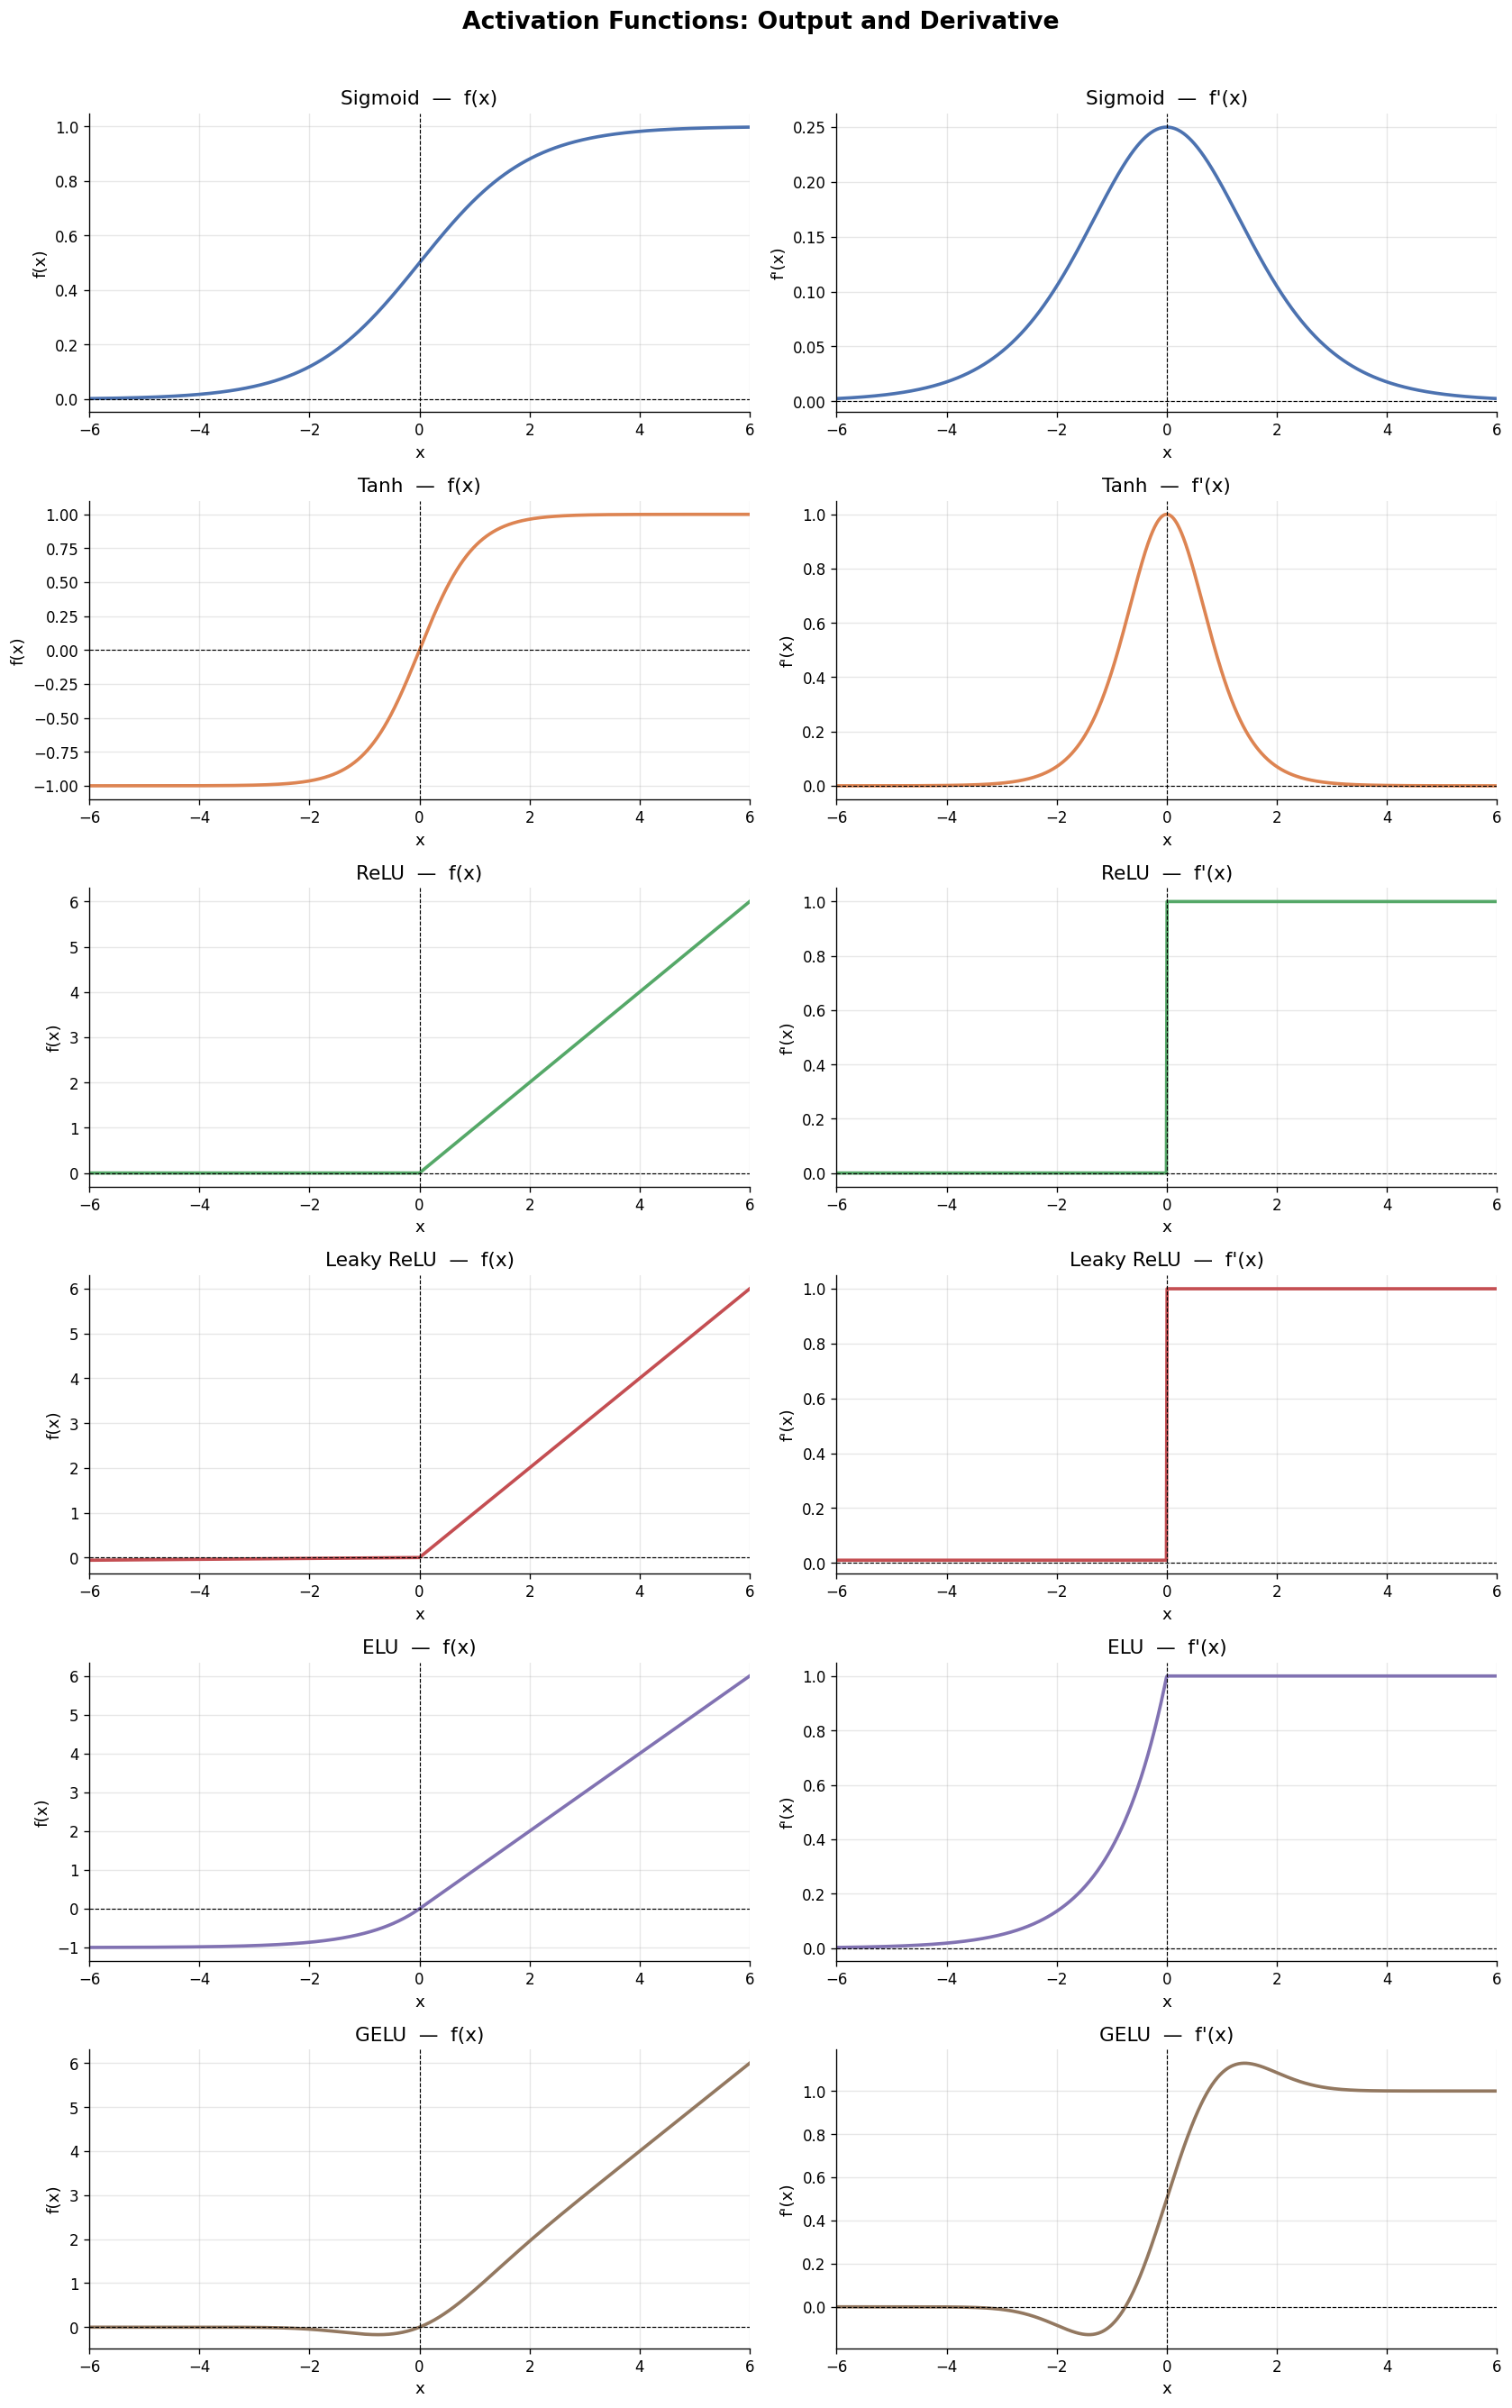

Plot saved.


In [3]:
fig, axes = plt.subplots(6, 2, figsize=(14, 22))
fig.suptitle('Activation Functions: Output and Derivative', fontsize=16, fontweight='bold', y=1.01)

for i, (name, (f_vals, df_vals)) in enumerate(functions.items()):
    color = colors[i]

    # Left: function output
    ax_f = axes[i, 0]
    ax_f.plot(x, f_vals, color=color, linewidth=2.2)
    ax_f.axhline(0, color='black', linewidth=0.7, linestyle='--')
    ax_f.axvline(0, color='black', linewidth=0.7, linestyle='--')
    ax_f.set_title(f'{name}  —  f(x)')
    ax_f.set_xlim(-6, 6)
    ax_f.set_xlabel('x')
    ax_f.set_ylabel('f(x)')

    # Right: derivative
    ax_d = axes[i, 1]
    ax_d.plot(x, df_vals, color=color, linewidth=2.2, linestyle='-')
    ax_d.axhline(0, color='black', linewidth=0.7, linestyle='--')
    ax_d.axvline(0, color='black', linewidth=0.7, linestyle='--')
    ax_d.set_title(f'{name}  —  f\'(x)')
    ax_d.set_xlim(-6, 6)
    ax_d.set_xlabel('x')
    ax_d.set_ylabel("f'(x)")

plt.tight_layout()
plt.savefig('activation_functions_grid.png', bbox_inches='tight')
plt.show()
print('Plot saved.')

---

## 3. ReLU vs GELU — A Close Comparison

ReLU and GELU are the two most relevant functions for modern deep learning. Let's compare them directly.

**ReLU** sets all negative inputs to exactly zero. This is computationally cheap, but:
- It creates a hard boundary at zero
- Neurons can "die" permanently if they consistently receive negative inputs

**GELU** applies a smooth, probabilistic gate. For large positive `x`, output approaches `x`. For large negative `x`, output approaches 0. Near zero, it blends — allowing some partial signal through. This smoothness helps gradient flow and is why Transformers prefer GELU.

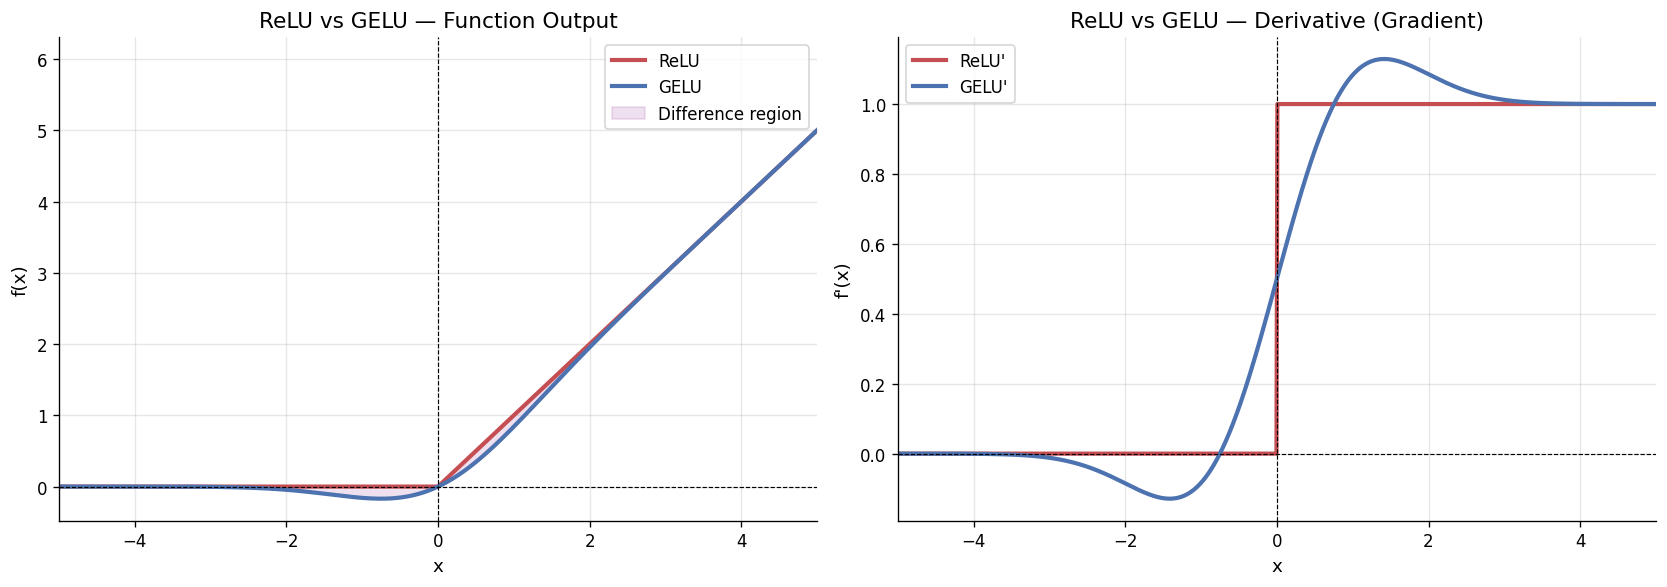

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Function comparison
ax = axes[0]
ax.plot(x, relu(x),  color='#C44E52', linewidth=2.5, label='ReLU')
ax.plot(x, gelu(x),  color='#4C72B0', linewidth=2.5, label='GELU')
ax.fill_between(x, relu(x), gelu(x), alpha=0.12, color='purple', label='Difference region')
ax.axhline(0, color='black', linewidth=0.7, linestyle='--')
ax.axvline(0, color='black', linewidth=0.7, linestyle='--')
ax.set_title('ReLU vs GELU — Function Output')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_xlim(-5, 5)
ax.legend()

# Panel 2: Derivative comparison
ax2 = axes[1]
ax2.plot(x, d_relu(x),  color='#C44E52', linewidth=2.5, label="ReLU'")
ax2.plot(x, d_gelu(x),  color='#4C72B0', linewidth=2.5, label="GELU'")
ax2.axhline(0, color='black', linewidth=0.7, linestyle='--')
ax2.axvline(0, color='black', linewidth=0.7, linestyle='--')
ax2.set_title('ReLU vs GELU — Derivative (Gradient)')
ax2.set_xlabel('x')
ax2.set_ylabel("f'(x)")
ax2.set_xlim(-5, 5)
ax2.legend()

plt.tight_layout()
plt.savefig('relu_vs_gelu.png', bbox_inches='tight')
plt.show()

**Key observation from the derivative plot:**

- ReLU's gradient is either exactly 0 (for x < 0) or exactly 1 (for x > 0). There is a hard jump at x = 0.
- GELU's gradient is smooth, starts near 0 for very negative x, rises through 1 near positive x, and peaks slightly above 1 around x = 0.8. This smooth gradient helps avoid abrupt gradient changes during training.

---

## 4. Behavior on Negative Inputs — The Dead Neuron Problem

A neuron is "dead" when its output is always zero, so its gradient is always zero, and it never updates. This is a real issue for ReLU.

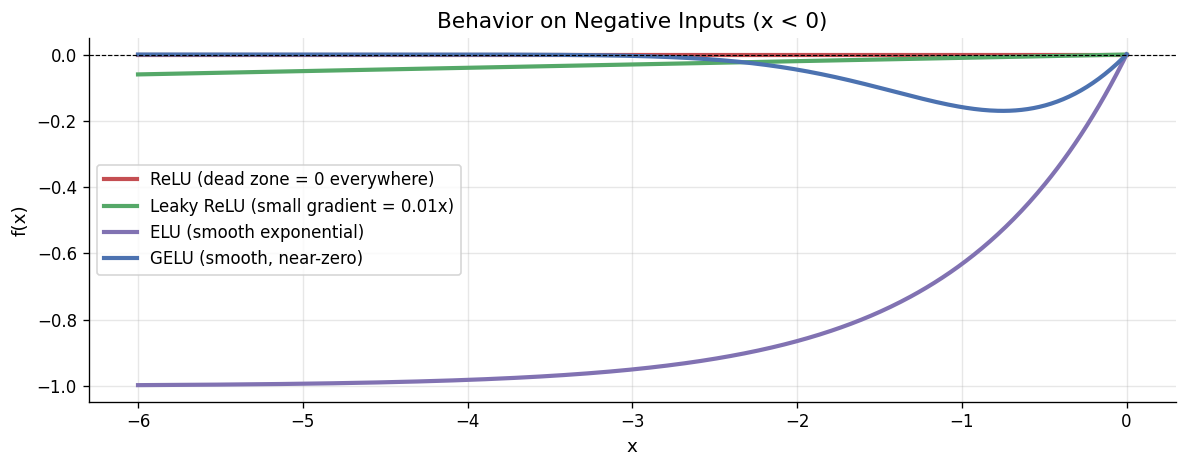

In [5]:
neg_x = np.linspace(-6, 0, 500)

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(neg_x, relu(neg_x),        color='#C44E52', linewidth=2.5, label='ReLU (dead zone = 0 everywhere)')
ax.plot(neg_x, leaky_relu(neg_x),  color='#55A868', linewidth=2.5, label='Leaky ReLU (small gradient = 0.01x)')
ax.plot(neg_x, elu(neg_x),         color='#8172B2', linewidth=2.5, label='ELU (smooth exponential)')
ax.plot(neg_x, gelu(neg_x),        color='#4C72B0', linewidth=2.5, label='GELU (smooth, near-zero)')

ax.axhline(0, color='black', linewidth=0.7, linestyle='--')
ax.set_title('Behavior on Negative Inputs (x < 0)')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()

plt.tight_layout()
plt.savefig('negative_inputs_behavior.png', bbox_inches='tight')
plt.show()

---

## 5. Output Range Comparison

The output range of an activation affects how inputs to subsequent layers are scaled.

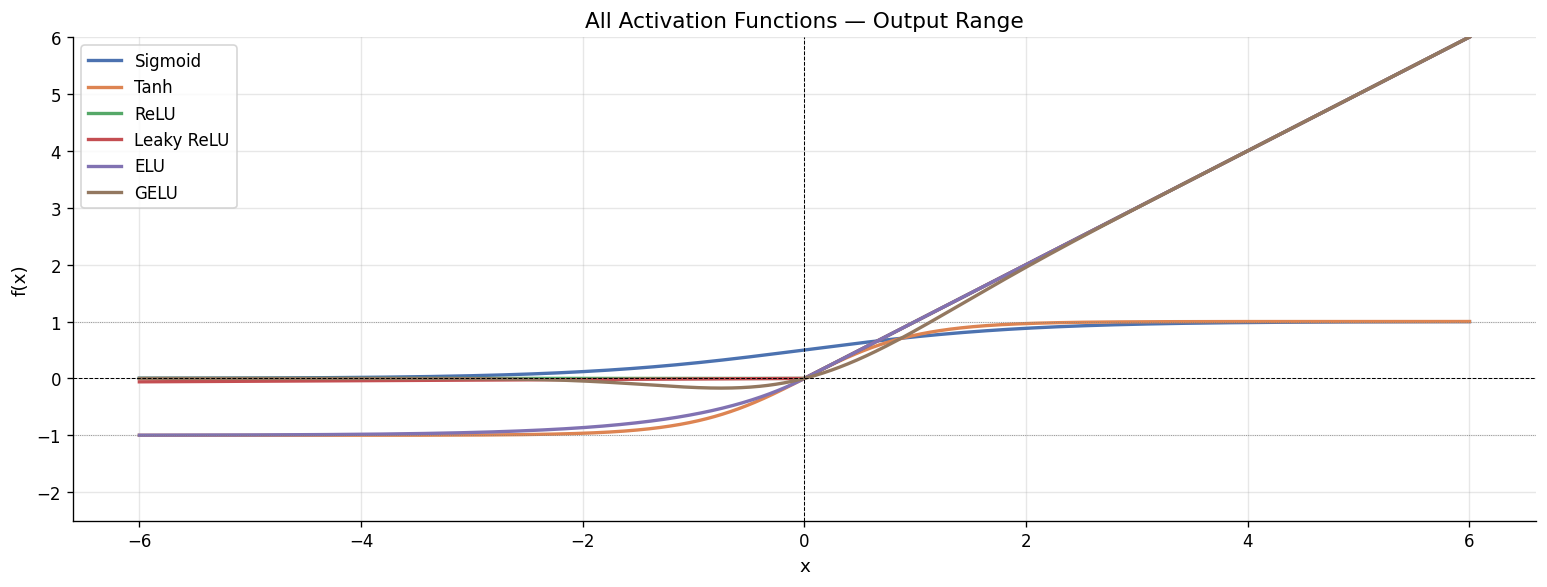

In [6]:
fig, ax = plt.subplots(figsize=(13, 5))

for i, (name, (f_vals, _)) in enumerate(functions.items()):
    ax.plot(x, f_vals, color=colors[i], linewidth=2.0, label=name)

ax.axhline(0,  color='black', linewidth=0.6, linestyle='--')
ax.axhline(1,  color='gray',  linewidth=0.5, linestyle=':')
ax.axhline(-1, color='gray',  linewidth=0.5, linestyle=':')
ax.axvline(0,  color='black', linewidth=0.6, linestyle='--')
ax.set_title('All Activation Functions — Output Range')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_ylim(-2.5, 6)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('all_functions_overlay.png', bbox_inches='tight')
plt.show()

---

## 6. Training Experiment: ReLU vs GELU on a Classification Task

Now let's go beyond theory. We'll train identical networks — one with ReLU, one with GELU — on a synthetic classification dataset and compare their learning curves.

The only difference between the two models is the activation function.

In [7]:
# Generate a binary classification dataset
X, y = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    random_state=42
)

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
def to_tensor(arr, dtype=torch.float32):
    return torch.tensor(arr, dtype=dtype)

X_train_t = to_tensor(X_train)
X_test_t  = to_tensor(X_test)
y_train_t = to_tensor(y_train, dtype=torch.long)
y_test_t  = to_tensor(y_test,  dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)

print(f'Training samples : {len(X_train)}')
print(f'Test samples     : {len(X_test)}')
print(f'Features         : {X_train.shape[1]}')

Training samples : 4000
Test samples     : 1000
Features         : 20


In [8]:
class MLP(nn.Module):
    """
    A simple 4-layer feedforward network.
    The activation function is passed in so we can swap ReLU vs GELU easily.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


def train_model(model, loader, epochs=40, lr=1e-3):
    """Train for a fixed number of epochs and record loss + accuracy per epoch."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0

        for xb, yb in loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(yb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total   += len(yb)

        train_losses.append(epoch_loss / total)
        train_accs.append(correct / total)

    return train_losses, train_accs


def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        preds = logits.argmax(dim=1).numpy()
    return accuracy_score(y.numpy(), preds)


# Shared hyperparameters
INPUT_DIM  = X_train.shape[1]
HIDDEN_DIM = 128
OUTPUT_DIM = 2
EPOCHS     = 50

# Build models
model_relu = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, activation=nn.ReLU())
model_gelu = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, activation=nn.GELU())

print('Models built. Training...')

relu_losses, relu_accs = train_model(model_relu, train_loader, epochs=EPOCHS)
gelu_losses, gelu_accs = train_model(model_gelu, train_loader, epochs=EPOCHS)

relu_test_acc = evaluate(model_relu, X_test_t, y_test_t)
gelu_test_acc = evaluate(model_gelu, X_test_t, y_test_t)

print(f'\nReLU — Final Test Accuracy: {relu_test_acc:.4f}')
print(f'GELU — Final Test Accuracy: {gelu_test_acc:.4f}')

Models built. Training...

ReLU — Final Test Accuracy: 0.9800
GELU — Final Test Accuracy: 0.9780


---

## 7. Learning Curves

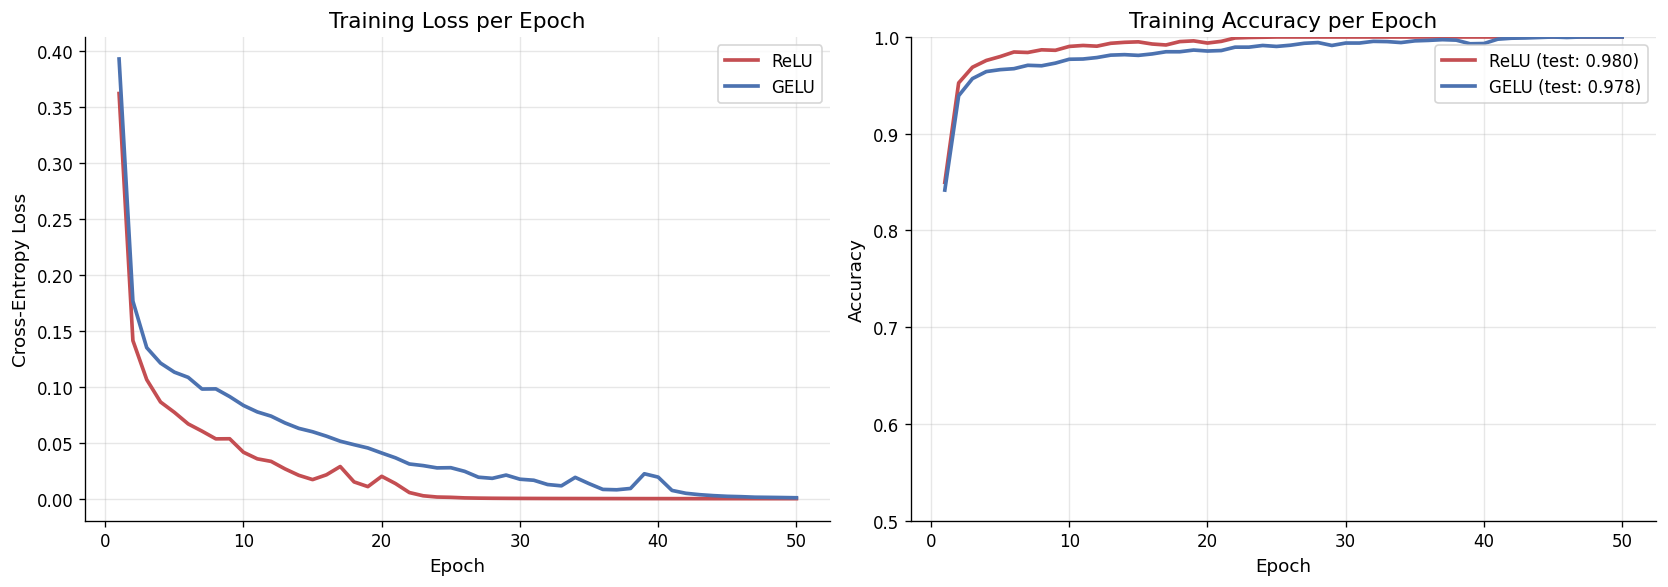

In [9]:
epochs_range = range(1, EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
ax = axes[0]
ax.plot(epochs_range, relu_losses, color='#C44E52', linewidth=2.2, label='ReLU')
ax.plot(epochs_range, gelu_losses, color='#4C72B0', linewidth=2.2, label='GELU')
ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-Entropy Loss')
ax.legend()

# Training Accuracy
ax2 = axes[1]
ax2.plot(epochs_range, relu_accs, color='#C44E52', linewidth=2.2, label=f'ReLU (test: {relu_test_acc:.3f})')
ax2.plot(epochs_range, gelu_accs, color='#4C72B0', linewidth=2.2, label=f'GELU (test: {gelu_test_acc:.3f})')
ax2.set_title('Training Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0.5, 1.0)
ax2.legend()

plt.tight_layout()
plt.savefig('training_curves.png', bbox_inches='tight')
plt.show()

---

## 8. Gradient Analysis — How Gradients Flow Through Each Function

During training, gradients must flow backward through the network. If an activation function kills gradients in certain regions, learning slows or stops. Here we show what fraction of the input range receives a non-zero gradient for each function.

In [10]:
test_range = np.linspace(-4, 4, 1000)

grad_data = {
    'Sigmoid':    d_sigmoid(test_range),
    'Tanh':       d_tanh(test_range),
    'ReLU':       d_relu(test_range),
    'Leaky ReLU': d_leaky_relu(test_range),
    'ELU':        d_elu(test_range),
    'GELU':       d_gelu(test_range),
}

# Fraction of inputs with gradient > threshold
THRESHOLD = 0.01
print(f'Fraction of inputs (x in [-4,4]) with |gradient| > {THRESHOLD}:')
print('-' * 40)
for name, grads in grad_data.items():
    frac = np.mean(np.abs(grads) > THRESHOLD)
    print(f'  {name:<14}: {frac:.2%}')

print()
print('Note: Higher fraction = more neurons receive gradients = more stable learning.')

Fraction of inputs (x in [-4,4]) with |gradient| > 0.01:
----------------------------------------
  Sigmoid       : 100.00%
  Tanh          : 74.80%
  ReLU          : 50.00%
  Leaky ReLU    : 50.00%
  ELU           : 100.00%
  GELU          : 87.70%

Note: Higher fraction = more neurons receive gradients = more stable learning.


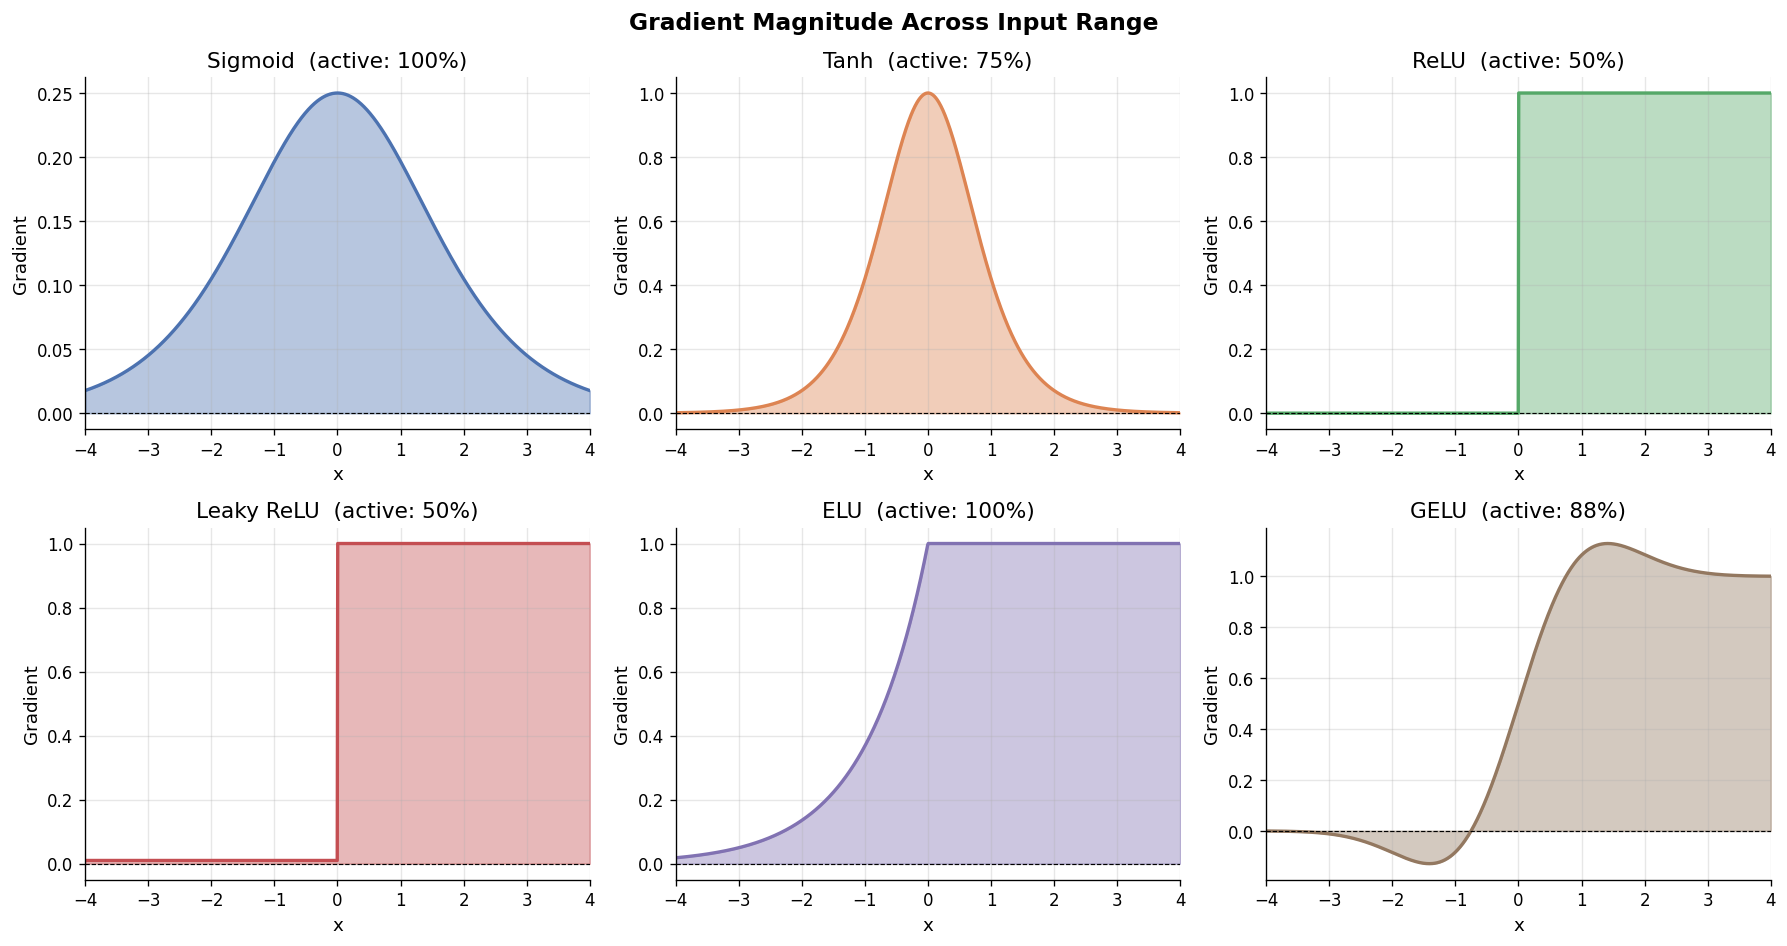

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (name, grads) in enumerate(grad_data.items()):
    ax = axes[i]
    ax.fill_between(test_range, grads, alpha=0.4, color=colors[i])
    ax.plot(test_range, grads, color=colors[i], linewidth=2.0)
    ax.axhline(0, color='black', linewidth=0.7, linestyle='--')
    frac = np.mean(np.abs(grads) > 0.01)
    ax.set_title(f'{name}  (active: {frac:.0%})')
    ax.set_xlabel('x')
    ax.set_ylabel("Gradient")
    ax.set_xlim(-4, 4)

plt.suptitle('Gradient Magnitude Across Input Range', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('gradient_analysis.png', bbox_inches='tight')
plt.show()

---

## 9. Summary Table

Here is a practical guide to choosing an activation function.

In [12]:
summary = {
    'Function':   ['Sigmoid', 'Tanh', 'ReLU', 'Leaky ReLU', 'ELU', 'GELU'],
    'Output Range': ['(0, 1)', '(-1, 1)', '[0, +inf)', '(-inf, +inf)', '(-alpha, +inf)', '~(-0.17, +inf)'],
    'Vanishing Gradient': ['Yes', 'Yes', 'Partial (dying)', 'No', 'No', 'No'],
    'Computationally Cheap': ['Medium', 'Medium', 'Very fast', 'Very fast', 'Moderate', 'Moderate'],
    'Best Use Case': [
        'Binary output layer',
        'RNNs, hidden layers',
        'CNNs, general default',
        'When dead neurons are an issue',
        'Deep networks needing smooth negatives',
        'Transformers, BERT, GPT'
    ]
}

import pandas as pd
df = pd.DataFrame(summary)
df.index = df.index + 1
print(df.to_string(index=False))

  Function   Output Range Vanishing Gradient Computationally Cheap                          Best Use Case
   Sigmoid         (0, 1)                Yes                Medium                    Binary output layer
      Tanh        (-1, 1)                Yes                Medium                    RNNs, hidden layers
      ReLU      [0, +inf)    Partial (dying)             Very fast                  CNNs, general default
Leaky ReLU   (-inf, +inf)                 No             Very fast         When dead neurons are an issue
       ELU (-alpha, +inf)                 No              Moderate Deep networks needing smooth negatives
      GELU ~(-0.17, +inf)                 No              Moderate                Transformers, BERT, GPT


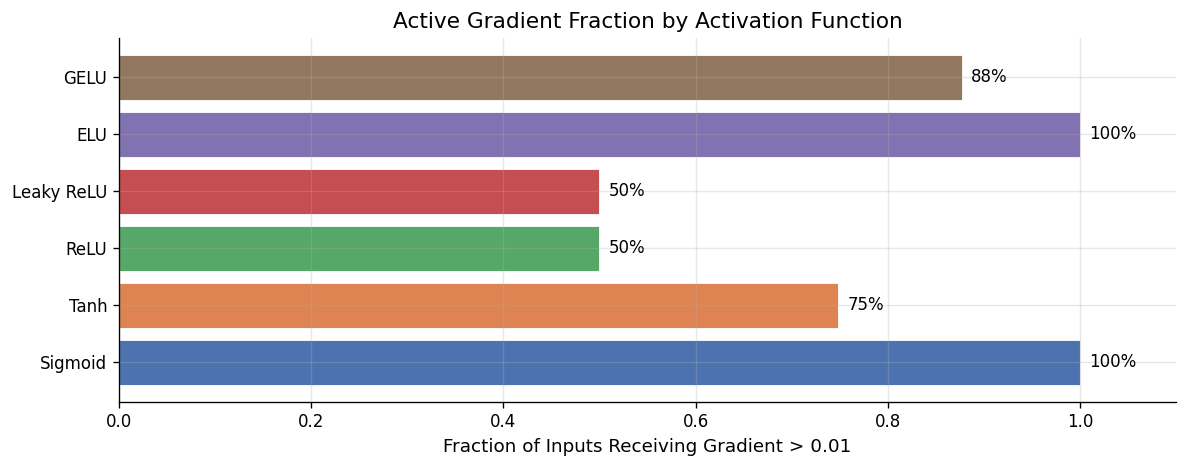

In [13]:
# Visual bar chart: training speed proxy (gradient active fraction)
names  = list(grad_data.keys())
fracs  = [np.mean(np.abs(g) > 0.01) for g in grad_data.values()]

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.barh(names, fracs, color=colors, edgecolor='white', linewidth=0.5)
ax.set_xlabel('Fraction of Inputs Receiving Gradient > 0.01')
ax.set_title('Active Gradient Fraction by Activation Function')
ax.set_xlim(0, 1.1)

for bar, frac in zip(bars, fracs):
    ax.text(frac + 0.01, bar.get_y() + bar.get_height()/2,
            f'{frac:.0%}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('active_gradient_fraction.png', bbox_inches='tight')
plt.show()

---

## 10. Key Takeaways

**ReLU** is still the default for most convolutional networks and tasks where speed matters. It is simple, fast to compute, and works well with proper weight initialization. The dying neuron problem can usually be managed with good learning rates and batch normalization.

**GELU** has become the standard in Transformer-based architectures (BERT, GPT, ViT). Its smooth gradient and probabilistic gating tend to produce slightly better convergence behavior, especially in deep networks where gradient flow is critical.

**Sigmoid and Tanh** are largely legacy choices for hidden layers due to vanishing gradients, but sigmoid remains useful at output layers for binary classification.

**Leaky ReLU and ELU** are good intermediate choices when you observe dead neurons with standard ReLU.

---

## Practical Decision Guide

- Building a CNN or standard MLP? Start with **ReLU**.
- Building a Transformer or attention-based model? Use **GELU**.
- Getting dead neurons? Switch to **Leaky ReLU** or **ELU**.
- Binary classification output? Use **Sigmoid**.
- Multiclass output? No activation (raw logits), let `CrossEntropyLoss` handle it.

---


*Notebook by: Lourdu Raju | Dataset: Synthetic (sklearn) | Framework: PyTorch*